In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import time
import numpy as np
import seaborn as sns

import figure_utils as utils
import matplotlib.pyplot as plt

from truncated_normal import truncated_normal as tn
from scipy.stats import norm, t, truncnorm, ttest_ind

def phi(z): return norm.pdf(z)
def Phi(z): return norm.cdf(z)

%matplotlib inline

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Figure 1

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


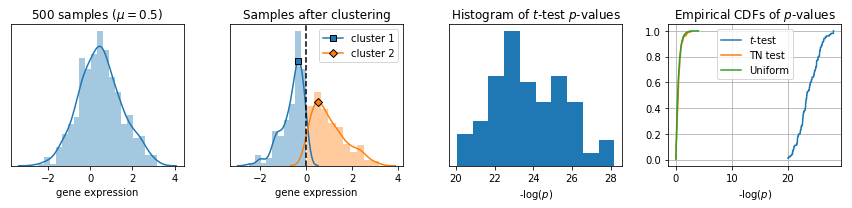

In [2]:
a = 0
mu = 0.5
muL = mu
muR = mu
Cov = 1

n = 500
nY = int(n*(1-Phi(muL)))
nZ = n-nY

np.random.seed(0)
y = truncnorm.rvs(a=-np.inf, b=a-muL, loc=muL, scale=np.sqrt(Cov), size=159)
z = truncnorm.rvs(a=a-muR, b=np.inf, loc=muR, scale=np.sqrt(Cov), size=341)

picklefile = 'pickled/sim_1d_null.pickle'
curves = pickle.load(open(picklefile, 'rb'))
curves['$t$-test'] = curves.pop('T test')
curves['TN test'] = curves.pop('TN test (var known)')
curves.pop('TN test (var unknown)')

plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
utils.plot_hists({'': np.hstack((y, z))}, value_name='gene expression',
           legend=False, add_markers=False, bins=20)
plt.yticks([])
plt.title('500 samples ($\mu = 0.5$)')
plt.subplot(1, 4, 2)
plt.yticks([])
utils.plot_hists({'cluster 1': y, 'cluster 2': z}, value_name='gene expression')
plt.axvline(x=a, color='k', linestyle='--')
plt.title('Samples after clustering')
plt.subplot(1, 4, 3)
plt.hist(-np.log10(curves['$t$-test']))
plt.xlabel('-log($p$)')
plt.yticks([])
plt.title('Histogram of $t$-test $p$-values')
plt.subplot(1, 4, 4)
utils.plot_ecdfs(curves)
plt.grid()
plt.title('Empirical CDFs of $p$-values')
plt.tight_layout()
plt.savefig('figures/sim_1D_example.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

# Figure 2

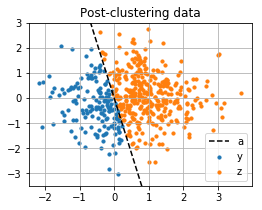

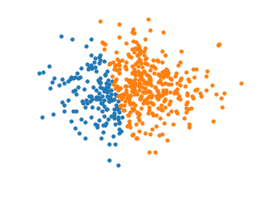

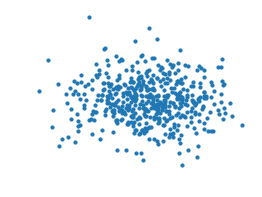

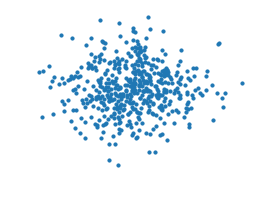

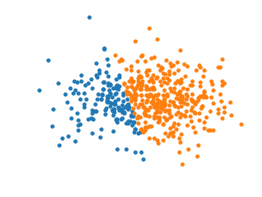

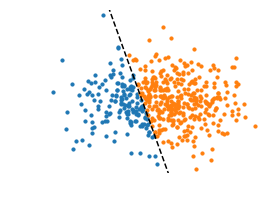

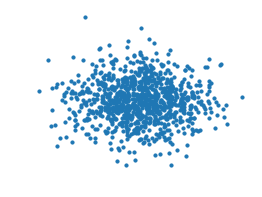

In [3]:
np.random.seed(0)
a = np.random.normal(0, 1, 2)
a /= np.linalg.norm(a)
mu = np.array([0.5, 0])
muL = mu
muR = mu
Cov = np.array([1., 1.])

n = 500
nY = int(n*Phi(-np.dot(a, muL)/np.sqrt(np.dot(a, Cov*a))))
nZ = n-nY

y = utils.truncnormmv(muL, Cov, -a, nY)
z = utils.truncnormmv(muR, Cov, a, nZ)

X2 = np.vstack((y, z))

plt.figure(figsize=(4, 3))
utils.plot_2D(a, y, z, ylim=(-3.5, 3), s=10)
plt.title('Post-clustering data')
plt.xlabel('')
plt.ylabel('')
plt.savefig('figures/methods_data.pdf', format='pdf', dpi=500, bbox_inches='tight')

plt.figure(figsize=(4, 3))
plt.scatter(y[:, 0], y[:, 1], s=10)
plt.scatter(z[:, 0], z[:, 1], s=10)
plt.axis('off')
plt.xlabel('')
plt.ylabel('')
plt.savefig('figures/methods_X2_labeled.pdf', format='pdf', dpi=500, bbox_inches='tight')

np.random.seed(1)
y = utils.truncnormmv(muL, Cov, -a, nY)
z = utils.truncnormmv(muR, Cov, a, nZ)
X1 = np.vstack((y, z))

plt.figure(figsize=(4, 3))
plt.scatter(X1[:, 0], X1[:, 1], s=10)
plt.axis('off')
plt.savefig('figures/methods_X1.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

plt.figure(figsize=(4, 3))
plt.scatter(X2[:, 0], X2[:, 1], s=10)
plt.axis('off')
plt.savefig('figures/methods_X2.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

plt.figure(figsize=(4, 3))
plt.scatter(y[:, 0], y[:, 1], s=10)
plt.scatter(z[:, 0], z[:, 1], s=10)
plt.axis('off')
plt.savefig('figures/methods_X1_labeled.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

plt.figure(figsize=(4, 3))
utils.plot_2D(a, y, z, ylim=(-3.2, 4.2), s=10, legend=False)
plt.axis('off')
plt.savefig('figures/methods_X1_labeled_axis.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

X = np.vstack((X1, X2))
plt.figure(figsize=(4, 3))
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.axis('off')
plt.savefig('figures/methods_X.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

457 iterations done; loss = -2.31e+02 (1.61 s elapsed).
[0.97106083 1.05487891]
[0.28777367 0.11842169]
[0.66868611 0.02206344]
[0.47822989 0.07024256]


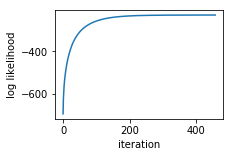

In [4]:
np.random.seed(0)
eta1, eta2, eta3, track = tn.get_natural_params_diagonal(y, z, a, 
                                                         num_iters=100000,
                                                         learning_rate=0.1,
                                                         verbose=True,
                                                         eps=1e-3)
var_hat = eta1**-1
muL_hat = var_hat*eta2
muR_hat = var_hat*eta3

plt.figure(figsize=(3, 2))
plt.plot(track)
plt.xlabel('iteration')
plt.ylabel('log likelihood')
plt.savefig('figures/methods_loss.pdf', format='pdf', dpi=500, bbox_inches='tight')

print(var_hat)
print(muL_hat)
print(muR_hat)
print((muL_hat+muR_hat)/2)

muY: -0.62, varY: 0.30, muZ: 0.98, varZ: 0.49, stat: 2.93, p: 0.00
muY: -0.17, varY: 1.02, muZ: 0.17, varZ: 1.03, stat: -0.95, p: 0.34
[5.13259214e-95 9.21109935e-03]


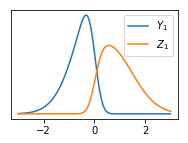

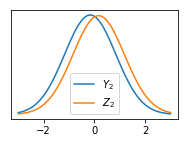

In [5]:
tx = np.linspace(-3, 3, 100)

ind = 0
mu = (muL_hat[ind]+muR_hat[ind])/2.
muL_, muR_ = np.array(muL_hat), np.array(muR_hat)
muL_[ind], muR_[ind] = mu, mu
pdfY, pdfZ = tn.get_marginals(a, muL_, muR_, var=var_hat, ind=ind)
muY, varY, muZ, varZ = tn.get_truncmv_params(a, muL_, muR_, var=var_hat, ind=ind)
stat = (np.sum(z[:, ind])-np.sum(y[:, ind])-(nZ*muZ-nY*muY))/np.sqrt(nY*varY+nZ*varZ)
p = np.min((norm.cdf(stat), norm.cdf(-stat)))*2
print('muY: %.2f, varY: %.2f, muZ: %.2f, varZ: %.2f, stat: %.2f, p: %.2f'\
      %(muY, varY, muZ, varZ, stat, p))
plt.figure(figsize=(3, 2))
plt.plot(tx, [pdfY(x) for x in tx], label='$Y_1$')
plt.plot(tx, [pdfZ(x) for x in tx], label='$Z_1$')
plt.yticks([])
plt.legend()
plt.savefig('figures/methods_marginal1.pdf', format='pdf', dpi=500, bbox_inches='tight')

ind = 1
mu = (muL_hat[ind]+muR_hat[ind])/2.
muL_, muR_ = np.array(muL_hat), np.array(muR_hat)
muL_[ind], muR_[ind] = mu, mu
pdfY, pdfZ = tn.get_marginals(a, muL_, muR_, var=var_hat, ind=ind)
muY, varY, muZ, varZ = tn.get_truncmv_params(a, muL_, muR_, var=var_hat, ind=ind)
stat = (np.sum(z[:, ind])-np.sum(y[:, ind])-(nZ*muZ-nY*muY))/np.sqrt(nY*varY+nZ*varZ)
p = np.min((norm.cdf(stat), norm.cdf(-stat)))*2
print('muY: %.2f, varY: %.2f, muZ: %.2f, varZ: %.2f, stat: %.2f, p: %.2f'\
      %(muY, varY, muZ, varZ, stat, p))
plt.figure(figsize=(3, 2))
plt.plot(tx, [pdfY(x) for x in tx], label='$Y_2$')
plt.plot(tx, [pdfZ(x) for x in tx], label='$Z_2$')
plt.yticks([])
plt.legend()
plt.savefig('figures/methods_marginal2.pdf', format='pdf', dpi=500, bbox_inches='tight')

print(ttest_ind(y, z)[1])

# Figure 3

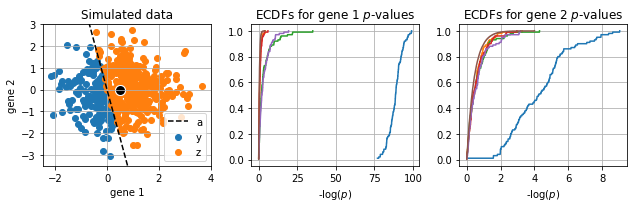

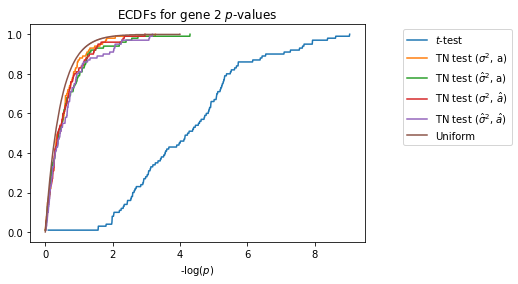

In [6]:
np.random.seed(0)
a = np.random.normal(0, 1, 2)
a /= np.linalg.norm(a)
mu = np.array([0.5, 0])
muL = mu
muR = mu
Cov = np.array([1., 1.])

n = 500
nY = int(n*Phi(-np.dot(a, muL)/np.sqrt(np.dot(a, Cov*a))))
nZ = n-nY

y = utils.truncnormmv(muL, Cov, -a, nY)
z = utils.truncnormmv(muR, Cov, a, nZ)

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
utils.plot_2D(a, y, z, muL=muL, muR=muR, ylim=(-3.5, 3))
plt.title('Simulated data')

picklefile = 'pickled/sim_2d_null_svm.pickle'
curves = pickle.load(open(picklefile, 'rb'))

for i in range(2):
    curves_ = {label:curves[label][:, i] for label in curves}
    curves_['$t$-test'] = curves_.pop('T test')
    curves_['TN test ($\sigma^2$, a)'] = curves_.pop('TN test (var known, a given)')
    curves_['TN test ($\hat{\sigma}^2$, a)'] = curves_.pop('TN test (var unknown, a given)')
    curves_['TN test ($\sigma^2$, $\hat{a}$)'] = curves_.pop('TN test (var known, a estimated)')
    curves_['TN test ($\hat{\sigma}^2$, $\hat{a}$)'] = curves_.pop('TN test (var unknown, a estimated)')
    plt.subplot(1, 3, i+2)
    utils.plot_ecdfs(curves_, title='ECDFs for gene %s $p$-values'%(i+1), logmode=False, legend=False)
    plt.grid()
    
plt.tight_layout()
plt.savefig('figures/sim_2D_null_example.pdf', format='pdf', dpi=500, bbox_inches='tight')

plt.figure()
utils.plot_ecdfs(curves_, title='ECDFs for gene %s $p$-values'%(i+1), logmode=False, legend=False)
plt.legend(bbox_to_anchor=(1.1, 1))
plt.savefig('figures/sim_2D_null_example_legend.pdf', format='pdf', dpi=500, bbox_inches='tight')

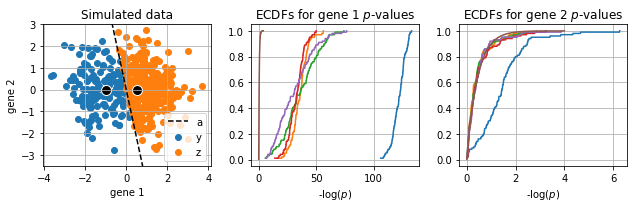

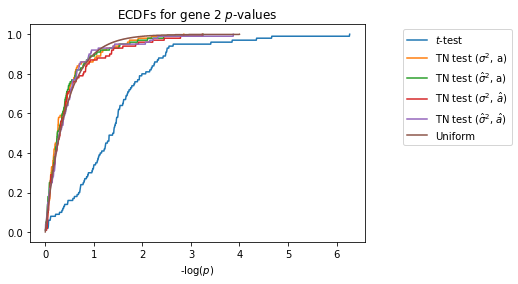

In [7]:
# changing only the mean of gene 1 in one of the distributions
np.random.seed(0)
muL = np.array([-1.0, 0])
muR = np.array([0.5, 0])

y = utils.truncnormmv(muL, Cov, -a, nY)
z = utils.truncnormmv(muR, Cov, a, nZ)

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
utils.plot_2D(a, y, z, muL=muL, muR=muR, ylim=(-3.5, 3))
plt.title('Simulated data')

picklefile = 'pickled/sim_2d_alt_svm.pickle'
curves = pickle.load(open(picklefile, 'rb'))

for i in range(2):
    curves_ = {label:curves[label][:, i] for label in curves}
    curves_['$t$-test'] = curves_.pop('T test')
    curves_['TN test ($\sigma^2$, a)'] = curves_.pop('TN test (var known, a given)')
    curves_['TN test ($\hat{\sigma}^2$, a)'] = curves_.pop('TN test (var unknown, a given)')
    curves_['TN test ($\sigma^2$, $\hat{a}$)'] = curves_.pop('TN test (var known, a estimated)')
    curves_['TN test ($\hat{\sigma}^2$, $\hat{a}$)'] = curves_.pop('TN test (var unknown, a estimated)')
    plt.subplot(1, 3, i+2)
    utils.plot_ecdfs(curves_, title='ECDFs for gene %s $p$-values'%(i+1), logmode=False, legend=False)
    plt.grid()
    
plt.tight_layout()
plt.savefig('figures/sim_2D_alt_example.pdf', format='pdf', dpi=500, bbox_inches='tight')

plt.figure()
utils.plot_ecdfs(curves_, title='ECDFs for gene %s $p$-values'%(i+1), logmode=False, legend=False)
plt.legend(bbox_to_anchor=(1.1, 1))
plt.savefig('figures/sim_2D_alt_example_legend.pdf', format='pdf', dpi=500, bbox_inches='tight')

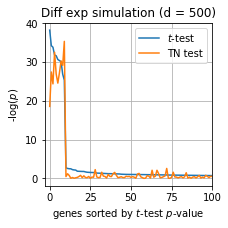

In [8]:
picklefile = 'pickled/sim_dsweep_alt.pickle'
p_t, p_tn = pickle.load(open(picklefile, 'rb'))

curves = {
    '$t$-test': p_t,
    'TN test': p_tn
}

plt.figure(figsize=(3, 3))
plt.plot(-np.log10(np.sort(p_t)[:200]), label='$t$-test')
plt.plot(-np.log10(p_tn), label='TN test')
plt.grid()
plt.xlabel('genes sorted by $t$-test $p$-value')
plt.ylabel('-log($p$)')
plt.title('Diff exp simulation (d = %s)'%(500))
plt.xlim(-3, 100)
plt.legend()
plt.savefig('figures/sim_larged_alt.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

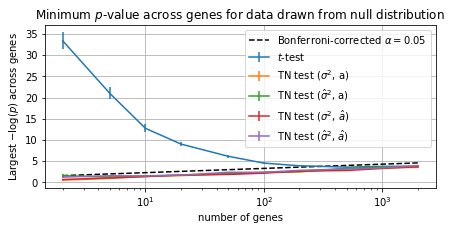

In [9]:
picklefile = 'pickled/sim_dsweep_null_svm.pickle'
d_list = [2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
num_sims = 10

results = pickle.load(open(picklefile, 'rb'))

for d in results:
    curves_ = results[d]
    curves_['$t$-test'] = curves_.pop('T test')
    curves_['TN test ($\sigma^2$, a)'] = curves_.pop('TN test (var known, a given)')
    curves_['TN test ($\hat{\sigma}^2$, a)'] = curves_.pop('TN test (var unknown, a given)')
    curves_['TN test ($\sigma^2$, $\hat{a}$)'] = curves_.pop('TN test (var known, a estimated)')
    curves_['TN test ($\hat{\sigma}^2$, $\hat{a}$)'] = curves_.pop('TN test (var unknown, a estimated)')
    results[d] = curves_

curve_types = list(results[d_list[0]].keys())
num_sims = len(results[d_list[0]][curve_types[0]])
alpha = 0.05

plt.figure(figsize=(7, 3))
for curve_type in curve_types:
    curve_set = [np.min(results[d][curve_type], 1) for d in d_list]
    means = [np.mean(-np.log10(curve)) for curve in curve_set]
    ses = [np.std(-np.log10(curve)/np.sqrt(num_sims)) for curve in curve_set]
    plt.errorbar(d_list, means, yerr=ses, label=curve_type)
    
plt.plot(d_list, -np.log10([alpha/d for d in d_list]), '--', 
         c='k', label=r'Bonferroni-corrected $\alpha = 0.05$')
plt.grid()

plt.xlabel(r'number of genes')
plt.xscale('log')
plt.ylabel(r'Largest $-\log(p)$ across genes')
plt.title('Minimum $p$-value across genes for data drawn from null distribution')
plt.legend()
plt.savefig('figures/sim_dsweep_null.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

# Figure 4

In [10]:
import pandas as pd

# Load data
data_dir = './'
data_R = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_preprocessed.txt'), delimiter=' ')
labels_R = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_labels.txt'), delimiter=' ')
tsne_R = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_tsne.txt'), delimiter=' ')
data = np.array(data_R).T
labels = np.array(labels_R).reshape(-1)
tsne = np.array(tsne_R)
genes = np.array(data_R.index)
keep_inds = np.loadtxt('pbmc_filtered_genes.txt').astype(bool)

p_t, p_tn = pickle.load(open('./pickled/pbmc_0v1.pickle', 'rb'))

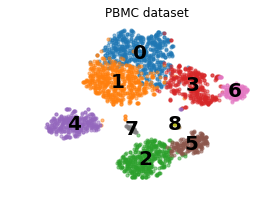

In [11]:
# Visualization of data
plt.figure(figsize=(4, 3))
utils.plot_labels_legend(tsne[:, 0], tsne[:, 1], labels, legend=False, overlay=True)
plt.title('PBMC dataset')
plt.axis('off')
plt.savefig('figures/pbmc_tsne.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log10


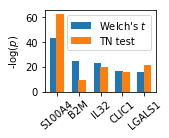

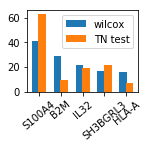

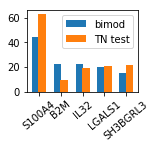

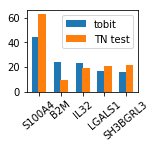

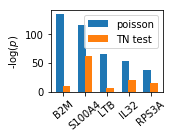

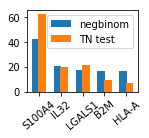

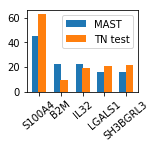

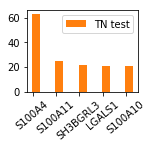

In [12]:
def get_gene_names(seurat_de, ngenes):
    gene_names = []
    p_seurat = []
    p_correct = []
    for i in range(ngenes):
        gene_names.append(seurat_de.index[i])
        p_seurat.append(seurat_de['p_val'][i])
        p_correct.append(-np.log10(p_tn[genes[keep_inds] == gene_names[-1]][0]))
    return gene_names, p_seurat, p_correct

def plot_bar_p(gene_names, p_correct, p_seurat=None, label=None, width=0.35, set_ylabel=True):
    fig, ax = plt.subplots(figsize=(2, 1.5))
    ind = np.arange(len(p_correct))
    if p_seurat is not None:
        rects = ax.bar(ind-0.2,
                       p_seurat, width,
                       align='center',
                       label=label)
        rects = ax.bar(ind-0.2+0.3,
                       p_correct, width,
                       align='center',
                       label='TN test')
    else:
        rects = ax.bar(ind,
                       p_correct, width,
                       align='center',
                       label='TN test',
                       color='#ff7f0e')
    if set_ylabel: ax.set_ylabel('-log($p$)')
    xticks_pos = [0.65*patch.get_width()+patch.get_xy()[0]-0.2 for patch in rects]
    plt.xticks(np.array(xticks_pos), gene_names, rotation=40)
    plt.legend()
    
tests = ["t",
        "wilcox",
        "bimod",
        "tobit",
        "poisson",
        "negbinom",
        "MAST"]

ngenes = 5
all_genes = []
for i, test in enumerate(tests):
    seurat_de = -np.log10(pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_de_%s.txt'%(test)), delimiter=' '))
    del seurat_de['avg_logFC']
    del seurat_de['pct.1']
    del seurat_de['pct.2']
    del seurat_de['p_val_adj']
    all_genes.extend(list(seurat_de.index[:10]))
    gene_names, p_seurat, p_correct = get_gene_names(seurat_de, ngenes)
    if test == "t": 
        test = 'Welch\'s $t$'
    plot_bar_p(gene_names, p_correct, p_seurat=p_seurat, label=test,
               set_ylabel = True if i == 0 or i == 4 else False)
    plt.savefig('figures/pbmc_de_%s.pdf'%(test), format='pdf', dpi=500, bbox_inches='tight')
    
inds = np.argsort(p_tn)[:ngenes]
p_correct = -np.log10(p_tn[inds])
gene_names = genes[keep_inds][inds]
plot_bar_p(gene_names, p_correct, set_ylabel=False)
plt.savefig('figures/pbmc_de_tn.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

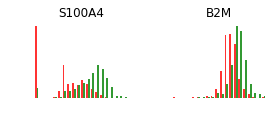

In [13]:
labels1 = np.array(pd.read_csv('./pbmc_seurat_0v1_cellsamplabels1.txt', delimiter=' ')).reshape(-1)
labels2 = np.loadtxt('./pbmc_seurat_0v1_cellsamplabels2.txt')

cellsamp1 = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_0v1_cellsamp1.txt'), delimiter=' ')
pdict = {j:i for i, j in enumerate(data_R.columns)}
inds1 = np.array([pdict[i] for i in np.array(cellsamp1).reshape(-1)])
cellsamp2 = np.loadtxt('./pbmc_seurat_0v1_cellsamp2.txt', dtype='str')
inds2 = np.array([pdict[i] for i in np.array(cellsamp2).reshape(-1)])

data1 = data[inds1]
data2 = data[inds2]

y1, z1 = data1[labels1 == 0], data1[labels1 == 1]
y2, z2 = data2[labels2 == 0], data2[labels2 == 1]

gene_names = ['S100A4', 'B2M']

plt.figure(figsize=(4, 1.8))
for i, gene_name in enumerate(gene_names):
    plt.subplot(1, 2, i+1)
    g_ind = np.where(genes == gene_name)[0][0]
    utils.plot_stacked_hist(np.vstack((y1, y2))[:, g_ind], np.vstack((z1, z2))[:, g_ind])
    plt.title(gene_name)
    plt.axis('off')
plt.tight_layout()
plt.savefig('figures/pbmc_gene_exp.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

In [14]:
np.mean(np.vstack((y1, y2))[:, g_ind])

5.053364135984385

In [15]:
np.mean( np.vstack((z1, z2))[:, g_ind])

5.362110877516974